# VAE



## Libraries


In [1]:
import numpy as np                              # Numpy
import tensorflow as tf                         # Tensorflow
from tensorflow import keras                    # Keras
from tensorflow.keras import layers             # Layers
import matplotlib.pyplot as plt                 # Plot

## Sampling Layer


In [2]:
class Sampling(layers.Layer):                               # Sampling class
 
    def call(self, inputs):                                 # Uses mean and log of standard deviation to sample 'Z'
        M, V = inputs                                       # Mean and log of variance
        B = tf.shape(M)[0]                                  # Batch
        D = tf.shape(M)[1]                                  # Dimention
        E = tf.keras.backend.random_normal(shape=(B, D))    # Epsilon
        return M + tf.exp(0.5 * V) * E                      # Return the sample

## Encoder


In [3]:
DL = 2                                                      # Latent vector dimention

I = keras.Input(shape=(2, 1), name="Input")                 # Input
X = layers.Flatten(name="Flatten")(I)                       # Flattened input
X = layers.Dense(256, activation="relu", name="H1")(X)      # First hidden layer
X = layers.Dense(256, activation="relu", name="H2")(X)      # Second hidden layer
M = layers.Dense(DL, name="Mean")(X)                        # Mean Layer
V = layers.Dense(DL, name="Variance")(X)                    # Variance Layer
Z = Sampling(name="Sampling")([M, V])                       # Sampling Layer
encoder = keras.Model(I, [M, V, Z], name="ENCODER")         # Encoder Model
encoder.summary()                                           # Printing the computational graph

Model: "ENCODER"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 2, 1)]       0                                            
__________________________________________________________________________________________________
Flatten (Flatten)               (None, 2)            0           Input[0][0]                      
__________________________________________________________________________________________________
H1 (Dense)                      (None, 256)          768         Flatten[0][0]                    
__________________________________________________________________________________________________
H2 (Dense)                      (None, 256)          65792       H1[0][0]                         
____________________________________________________________________________________________

## Decoder


In [4]:
LI = keras.Input(shape=(DL,))                                           # Input from latent layer
X = layers.Dense(256, activation="relu", name="H1")(LI)                 # First hidden layer
X = layers.Dense(256, activation="relu", name="H2")(X)                  # Second hidden layer
DO = layers.Dense(2, activation="sigmoid", name="Output")(X)            # Output layer
DO = layers.Reshape((2, 1), name="Reshape")(DO)                         # Reshaping the output
decoder = keras.Model(LI, DO, name="DECODER")                           # Decoder Model
decoder.summary()                                                       # Printing the computational graph

Model: "DECODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
H1 (Dense)                   (None, 256)               768       
_________________________________________________________________
H2 (Dense)                   (None, 256)               65792     
_________________________________________________________________
Output (Dense)               (None, 2)                 514       
_________________________________________________________________
Reshape (Reshape)            (None, 2, 1)              0         
Total params: 67,074
Trainable params: 67,074
Non-trainable params: 0
_________________________________________________________________


## VAE Model


In [19]:
class VAE(keras.Model):

    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:                                                   # Record operations for gradient calculation
            M, V, Z = encoder(data)                                                       # Mean, Variance, Latent Variable
            reconstruction = decoder(Z)                                                   # Reconstruction
            RL = tf.reduce_mean(keras.losses.binary_crossentropy(data, reconstruction))   # Reconstruction Loss
            RL *= 2 * 1                                                                   # Scale
            KLL = 1 + V - tf.square(M) - tf.exp(V)                                        # KL Divergence Loss
            KLL = tf.reduce_mean(KLL)                                                     # Compute mean across dimentions
            KLL *= -0.5                                                                   # Apply the formula
            L = RL + KLL                                                                  # Compute total loss
        grads = tape.gradient(L, self.trainable_weights)                                  # Calculate gradients
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))                # Apply the processed gradients
        
        return {
            "L": L,                                                                       # Total Loss
            "RL": RL,                                                                     # Reconstruction Loss
            "KLL": KLL,                                                                   # KL Divergence Loss
        }

## Load Data

In [6]:
train = np.load("FireEvac_train_set.npy")
test = np.load("FireEvac_test_set.npy")

fire_train = np.expand_dims(train, -1).astype("float32") / 255           # Concatenate train and test sets
fire_test = np.expand_dims(test, -1).astype("float32") / 255             # Normalize

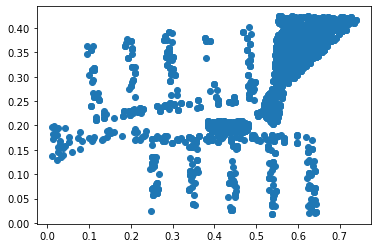

In [7]:
plt.plot(fire_train[:,0], fire_train[:,1], 'o');

In [20]:
vae = VAE(encoder, decoder)                                             # Model of VAE
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))       # Adam optimizer with LR = 0.001

losses = {'L': [], 'RL': [], 'KLL': []}

h1 = vae.fit(fire_train, epochs=100, batch_size=128)                      # 1 epoch trained, plotted
losses['L'].extend(h1.history['L'])
losses['RL'].extend(h1.history['RL'])
losses['KLL'].extend(h1.history['KLL'])
print(losses)
print(h1.history)

Epoch 1/100
24/24 [==============================] - 0s 3ms/step - L: 1.2960 - RL: 1.2960 - KLL: 2.8014e-08
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - L: 1.2956 - RL: 1.2956 - KLL: 2.3842e-09
Epoch 3/100
24/24 [==============================] - 0s 3ms/step - L: 1.2957 - RL: 1.2957 - KLL: 0.0000e+00
Epoch 4/100
24/24 [==============================] - 0s 2ms/step - L: 1.2962 - RL: 1.2962 - KLL: 0.0000e+00
Epoch 5/100
24/24 [==============================] - 0s 2ms/step - L: 1.2958 - RL: 1.2958 - KLL: 0.0000e+00
Epoch 6/100
24/24 [==============================] - 0s 2ms/step - L: 1.2942 - RL: 1.2942 - KLL: 0.0000e+00
Epoch 7/100
24/24 [==============================] - 0s 2ms/step - L: 1.2946 - RL: 1.2946 - KLL: 0.0000e+00
Epoch 8/100
24/24 [==============================] - 0s 2ms/step - L: 1.2954 - RL: 1.2954 - KLL: 0.0000e+00
Epoch 9/100
24/24 [==============================] - 0s 2ms/step - L: 1.2959 - RL: 1.2959 - KLL: 0.0000e+00
Epoch 10/100
24/24 [========

24/24 [==============================] - 0s 2ms/step - L: 1.2953 - RL: 1.2953 - KLL: 5.9605e-10
Epoch 77/100
24/24 [==============================] - 0s 2ms/step - L: 1.2944 - RL: 1.2944 - KLL: 5.9605e-10
Epoch 78/100
24/24 [==============================] - 0s 2ms/step - L: 1.2954 - RL: 1.2954 - KLL: 1.1921e-09
Epoch 79/100
24/24 [==============================] - 0s 2ms/step - L: 1.2949 - RL: 1.2949 - KLL: 0.0000e+00
Epoch 80/100
24/24 [==============================] - 0s 2ms/step - L: 1.2950 - RL: 1.2950 - KLL: 0.0000e+00
Epoch 81/100
24/24 [==============================] - 0s 2ms/step - L: 1.2952 - RL: 1.2952 - KLL: 0.0000e+00
Epoch 82/100
24/24 [==============================] - 0s 2ms/step - L: 1.2965 - RL: 1.2965 - KLL: 0.0000e+00
Epoch 83/100
24/24 [==============================] - 0s 2ms/step - L: 1.2954 - RL: 1.2954 - KLL: 0.0000e+00
Epoch 84/100
24/24 [==============================] - 0s 2ms/step - L: 1.2962 - RL: 1.2962 - KLL: 0.0000e+00
Epoch 85/100
24/24 [============

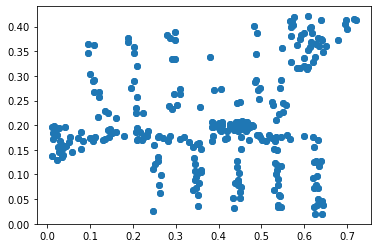

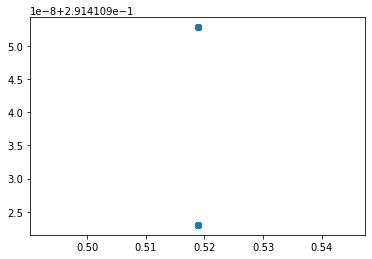

In [22]:
x_e = encoder.predict(fire_test)
x_d = decoder.predict(x_e)
x_reconstruct = x_d

plt.plot(fire_test[:,0], fire_test[:,1], 'o');
plt.show()
plt.plot(x_reconstruct[:,0], x_reconstruct[:,1], 'o');
plt.show()